In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from combat.pycombat import pycombat

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, KFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

from pymrmre import mrmr
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore', module='pymrmre')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [71]:
def data_load_preprocess():
    
    # load and drop all-NaN rows
    met_df = (pd.read_csv("./novi/data_zscore_comp_id.csv"))
    met_df.set_index('Unnamed: 0', inplace=True)
    met_df.index.name = None
    met_df.dropna(axis=0, how='all', inplace=True)
    
    # drop rows containing >80% NaN
    perc = 0.8
    min_count =  int((1 - perc)*met_df.shape[1] + 1)
    met_df.dropna(axis=0, thresh=min_count, inplace=True)
    
    # fill rest of NaN values     
    met_df.fillna(0, inplace=True)
    met_df = met_df.T
    
    # batch effect correction
    clin_df = pd.read_csv("./novi/sampleAttr.csv")
    met_df_corrected = pycombat(met_df.T, clin_df['STUDY'].values).T
    
    # drop outliers
    outliers = [17, 163, 222, 225, 255, 293, 362]
    met_df_corrected.drop(met_df_corrected.iloc[outliers].index, axis=0, inplace=True)
    
    # drop columns with unknown metabolites
    comp_df = pd.read_csv('./novi/compAnno.csv')
    unknown = comp_df[comp_df.BIOCHEMICAL.str.contains('X-[0-9]*')].COMP_ID
    met_df_corrected.drop(unknown, axis=1, inplace=True, errors='ignore')
    
    # join: gestation week, aspirin, preeclampsia, trimester
    target = clin_df[['ga.w', 'ASA', 'pe', 'trimester']]
    target.index = met_df.index
    df = met_df_corrected.join(target)
    
    # drop non-pe data
    df.drop(df[df.pe == 0].index, axis=0, inplace=True)
    df.drop(['pe'], axis=1, inplace=True)
    
    # train on control group, test on aspirin group
    train_df = df[df.ASA == False].drop(['ASA'], axis=1)
    test_df = df[df.ASA == True].drop(['ASA'], axis=1)
    
    
    # drop false data (ga.w < 25 & trim=3)
    b = train_df[train_df.trimester == 3]
    i = b[b['ga.w'] < 25].index
    train_df.drop(i, inplace=True)


    # use first trimester as train data (before aspirin treatmant)
    train_df = train_df.append(test_df[test_df.trimester == 1])
    test_df.drop(test_df[test_df.trimester == 1].index, axis=0, inplace=True)
    
    return train_df, test_df

In [3]:
from sklearn.metrics import make_scorer

def mean_error(y_true, y_pred):
    return np.mean(y_true - y_pred)

mean_error_scorer = make_scorer(mean_error, greater_is_better=False)
mean_absolute_error_scorer = make_scorer(mean_absolute_error, greater_is_better=True)
mean_squared_error_scorer = make_scorer(mean_squared_error, greater_is_better=True)
r2_scorer = make_scorer(r2_score)

# nested cross validation
def get_best_params_reg(pipeline, params, X, y):
    
    grid = GridSearchCV(pipeline, param_grid=params, cv=KFold(n_splits=5, shuffle=True, random_state=7), 
                        scoring='neg_mean_squared_error', n_jobs=-1)

    cv = KFold(n_splits=5, shuffle=True, random_state=7)
    scoring = {
    'mean_error': mean_error_scorer,
    'mean_absolute_error': mean_absolute_error_scorer,
    'mean_squared_error': mean_squared_error_scorer,
    'r2': r2_scorer
}
    
    scores = cross_validate(grid, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    
    grid.fit(X, y)
    best_params = grid.best_params_

    return scores, best_params 

In [4]:
pipe = Pipeline([('scaler', StandardScaler()), ('regressor', XGBRegressor(objective='reg:squarederror'))])
params = {
    'regressor__n_estimators' : [100, 200, 300],
    'regressor__max_depth' : [5, 10, 15],
    'regressor__learning_rate' : [0.01, 0.1, 1]
}


In [5]:
df_train, df_test = data_load_preprocess()
X = df_train.drop(['ga.w', 'trimester'], axis=1)
y = df_train['ga.w']
print('\nShape: ', X.shape, y.shape)

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data

Shape:  (46, 798) (46,)


/home/lucija/.local/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


In [1]:
# uncomment for nested cv:

# scores, best_params = get_best_params_reg(pipe, params, X, y)
# print(scores)

# for k, v in scores.items():
#     print(k, np.mean(v))

# print(best_params)


### saved scores output:
 
 {'fit_time': array([220.34272289, 219.65278292, 219.94975567, 220.19927287, 220.04858589]),
 
 'score_time': array([0.01212096, 0.01717782, 0.01474404, 0.01697278, 0.01698613]),
 
 'test_mean_error': array([-0.41916865, -0.67298173,  0.73988119,  0.84136396,  0.23471743]),
 
 'test_mean_absolute_error': array([1.15184764, 0.93881567, 0.99256977, 1.60586266, 0.74115724]),
 
 'test_mean_squared_error': array([3.21116726, 1.43391852, 1.44015574, 7.85330054, 0.69911276]),
 
 'test_r2': array([0.82353133, 0.90685941, 0.89655105, 0.4737566 , 0.95459727])}
 
 ________
 
 ### saved best params
 
{'regressor__learning_rate': 0.1,
 'regressor__max_depth': 5,
 'regressor__n_estimators': 200}


In [7]:
# best params saved for quick run
best_params = {'regressor__learning_rate': 0.1,
               'regressor__max_depth': 5,
               'regressor__n_estimators': 200}


In [8]:
pipe.set_params(**best_params)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [9]:
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

## scores on aspirin data

In [12]:
df_test = df_test[df_test.trimester == 2]
X_asa = df_test.drop(['ga.w', 'trimester'], axis=1)
y_asa = df_test['ga.w']

In [13]:
y_pred = pipe.predict(X_asa)

In [14]:
mean_squared_error(y_asa, y_pred)

38.64062612083488

In [15]:
mean_absolute_error(y_asa, y_pred)

5.593030725206647

In [16]:
mean_error(y_asa, y_pred)

5.593030725206647

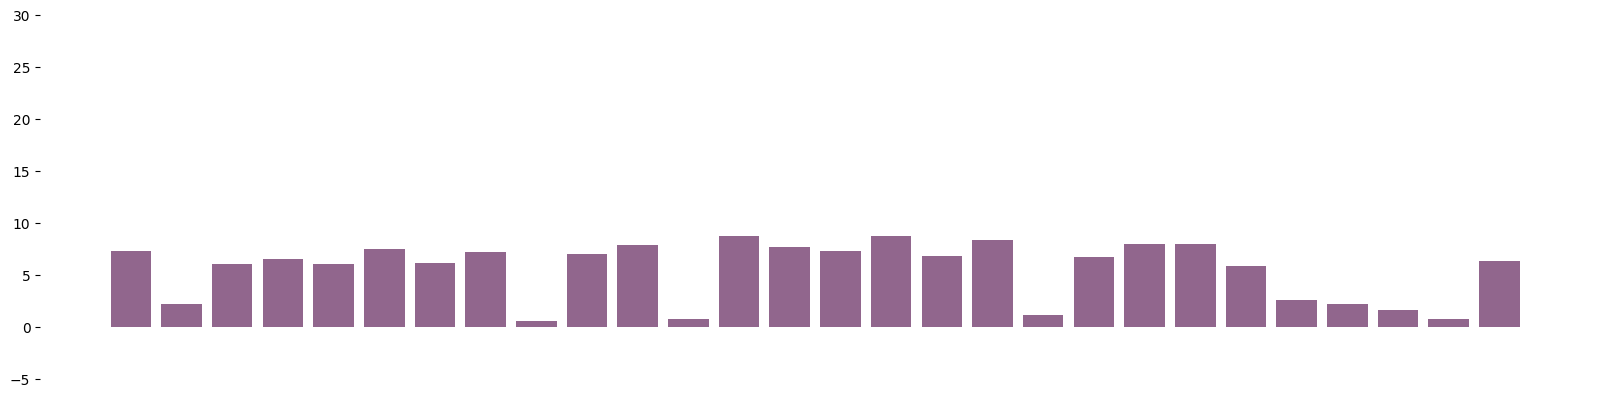

In [17]:
y_plot = [y_asa[i] - y_pred[i] for i in range(y_asa.shape[0])]
plt.figure(figsize=(20, 5))
plt.bar(range(y_asa.shape[0]), y_plot, color='#91668d')
# plt.title('Greske modela na podacima iz aspirin grupe')
plt.box(False)
plt.xticks(ticks=[], labels=[])
plt.ylim(-7, 30)
plt.show()

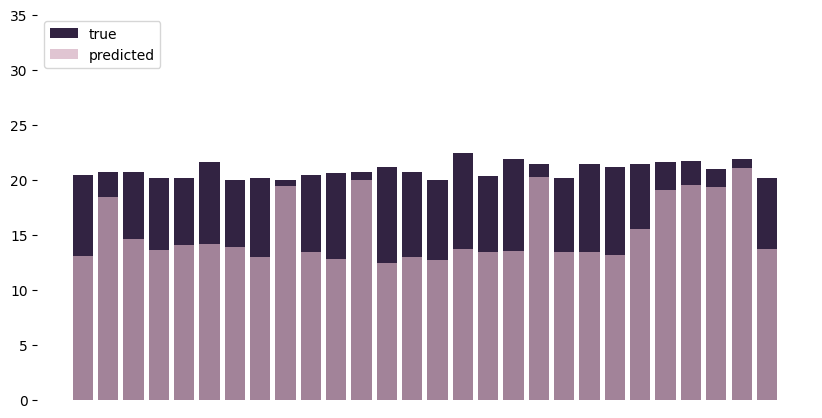

In [18]:
plt.figure(figsize=(10, 5))
plt.bar(range(y_asa.shape[0]), y_asa, color= '#322342')
plt.bar(range(y_asa.shape[0]), y_pred, color= '#d3adbf', alpha=0.7)
plt.legend(['true', 'predicted'], loc='upper left')
# plt.title('Poredjenje stvarnih i predvidjenih vrednosti za podatke iz aspirin grupe')
plt.box(False)
plt.ylim(0, 35)
plt.xticks(ticks=[], labels=[])
plt.show()

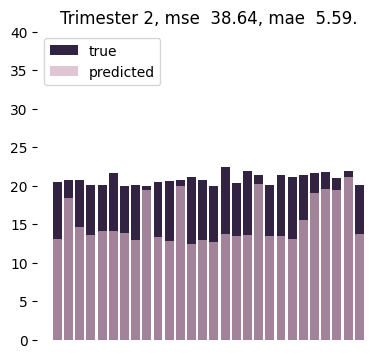

In [20]:
# separate 2. and 3. trimester -> t in range(2, 4) 
plt.figure(figsize=(15, 4))

for t in range(2, 3):
    test1 = df_test[df_test.trimester == t]
    X1 = test1.drop([ 'ga.w', 'trimester'], axis=1)
    y1 = test1['ga.w']
    pred1 = pipe.predict(X1)
    
    plt.subplot(1, 3, t)
    plt.bar(range(y1.shape[0]), y1, color= '#322342')
    plt.bar(range(y1.shape[0]), pred1, color= '#d3adbf', alpha=0.7)
    plt.legend(['true', 'predicted'], loc='upper left')
    plt.box(False)
    plt.title(f'Trimester {t}, mse {mean_squared_error(y1, pred1) : .2f}, mae {mean_absolute_error(y1, pred1) : .2f}.')
    plt.ylim(0, 40)
    plt.xticks(ticks=[], labels=[])
plt.show()

## OPLS

In [21]:
# !pip install pyopls

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for pyopls: filename=pyopls-20.3.post1-py3-none-any.whl size=19455 sha256=3798420c5d384e1c29bf8fe6e554686205868d289d5ec5c069ed96b3a2338f05
  Stored in directory: /home/lucija/.cache/pip/wheels/bb/da/70/ac90670a0c826877f65a85eed6a9c06e82e8a57f29fbd423c6
Successfully built pyopls


In [22]:
from pyopls import OPLS

In [72]:
pl, asa = data_load_preprocess()

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/home/lucija/.local/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


In [73]:
X = pl.drop(['ga.w', 'trimester'], axis=1)
y = pl['ga.w']
print('\nShape: ', X.shape, y.shape)


Shape:  (73, 798) (73,)


In [3]:
# create Pipeline with O-PLS
pipe = Pipeline([('scaler', StandardScaler()), ('opls', OPLS()), ('regressor', XGBRegressor(objective='reg:squarederror'))])
params = {
    'opls__n_components' : [1, 2, 3, 4, 5],
    'regressor__n_estimators' : [100, 200, 300],
    'regressor__max_depth' : [5, 10, 15],
    'regressor__learning_rate' : [0.01, 0.1, 1]
}

NameError: name 'Pipeline' is not defined

In [91]:
# uncomment to run nested cv

# scores, best_params = get_best_params_reg(pipe, params, X, y)
# print(scores)

# for k, v in scores.items():
#     print(k, np.mean(v))
    
# print(best_params)

{'fit_time': array([1165.47304082, 1161.11078405, 1162.06232429, 1165.04317999,
       1164.51112628]), 'score_time': array([0.00489092, 0.00994325, 0.009799  , 0.0056715 , 0.00431561]), 'test_mean_error': array([-0.09621174, -1.06450712,  0.76257578, -0.2868457 , -0.09301322]), 'test_mean_absolute_error': array([1.12796419, 1.13609278, 1.1376981 , 0.76791991, 0.90400514]), 'test_mean_squared_error': array([2.79363905, 4.33972735, 1.77593016, 1.09608075, 1.35612708]), 'test_r2': array([0.84647646, 0.71811176, 0.87243178, 0.9265525 , 0.91192856])}
fit_time 1163.640091085434
score_time 0.006924057006835937
test_mean_error -0.1556004021832702
test_mean_absolute_error 1.0147360243764856
test_mean_squared_error 2.272300879376514
test_r2 0.8551002137345437
{'opls__n_components': 1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 200}


### saved scores output

{'fit_time': array([1165.47304082, 1161.11078405, 1162.06232429, 1165.04317999, 1164.51112628]), 

'score_time': array([0.00489092, 0.00994325, 0.009799  , 0.0056715 , 0.00431561]), 

'test_mean_error': array([-0.09621174, -1.06450712,  0.76257578, -0.2868457 , -0.09301322]), 

'test_mean_absolute_error': array([1.12796419, 1.13609278, 1.1376981 , 0.76791991, 0.90400514]), 

'test_mean_squared_error': array([2.79363905, 4.33972735, 1.77593016, 1.09608075, 1.35612708]), 

'test_r2': array([0.84647646, 0.71811176, 0.87243178, 0.9265525 , 0.91192856])}

_____________
fit_time 1163.640091085434

score_time 0.006924057006835937

test_mean_error -0.1556004021832702

test_mean_absolute_error 1.0147360243764856

test_mean_squared_error 2.272300879376514

test_r2 0.8551002137345437

_____

### saved best params
{'opls__n_components': 1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 200}

In [96]:
# best params saved for quick run
best_params = {
    'opls__n_components': 1, 
    'regressor__learning_rate': 0.1, 
    'regressor__max_depth': 10, 
    'regressor__n_estimators': 200
}

pipe.set_params(**best_params)
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('opls', OPLS(n_components=1)),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

### scores on aspirin data

In [97]:
asa.drop(asa[asa.trimester == 3].index, axis=0, inplace=True)
X_asa = asa.drop(['ga.w', 'trimester'], axis=1)
y_asa = asa['ga.w']

In [100]:
y_pred = pipe.predict(X_asa)
print('mean squared error ', mean_squared_error(y_asa, y_pred))
print('mean absolute error ', mean_absolute_error(y_asa, y_pred))
print('mean error ', mean_error(y_asa, y_pred))


mean squared error  18.909782952427943
mean absolute error  3.483755104882376
mean error  3.321192571095058


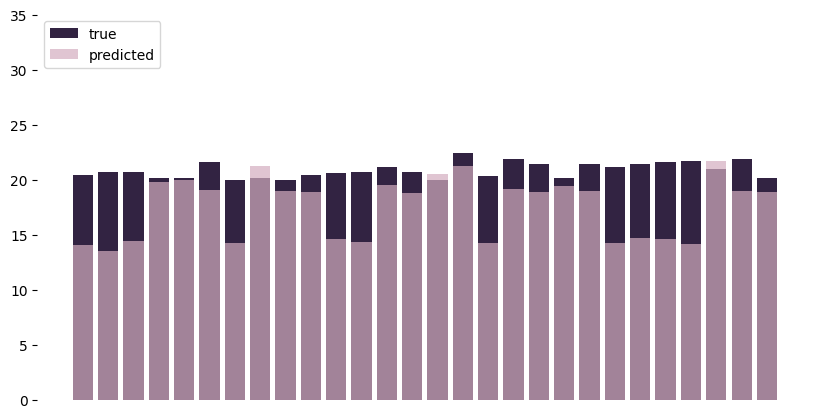

In [99]:
plt.figure(figsize=(10, 5))
plt.bar(range(y_asa.shape[0]), y_asa, color= '#322342')
plt.bar(range(y_asa.shape[0]), y_pred, color= '#d3adbf', alpha=0.7)
plt.legend(['true', 'predicted'], loc='upper left')
# plt.title('Poredjenje stvarnih i predvidjenih vrednosti za podatke iz aspirin grupe')
plt.box(False)
plt.ylim(0, 35)
plt.xticks(ticks=[], labels=[])
plt.show()